 # Netflix Movies and TV Shows Clustering

In [42]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# 1. Data Collection & Exploration


In [44]:
df = pd.read_csv("NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [45]:
df.shape

(7787, 12)

In [46]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [47]:
# Missing values
df.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [48]:
df_cleaned = df.copy()
# Handling missing values
df_cleaned['director'].fillna('Unknown', inplace=True)
df_cleaned['cast'].fillna('Not Specified', inplace=True)
most_common_country = df_cleaned['country'].mode()[0]
df_cleaned['country'].fillna(most_common_country, inplace=True)

# Check for duplicate records
duplicates = df_cleaned.duplicated().sum()
# Basic structure of the dataset
structure_info = df_cleaned.info()
# Check for inconsistencies in key categorical columns (unique values)
unique_types = df_cleaned['type'].unique()
unique_ratings = df_cleaned['rating'].unique()

duplicates, unique_types, unique_ratings



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      7787 non-null   object
 4   cast          7787 non-null   object
 5   country       7787 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


(0,
 array(['TV Show', 'Movie'], dtype=object),
 array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
        'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object))

Text(0, 0.5, 'Count')

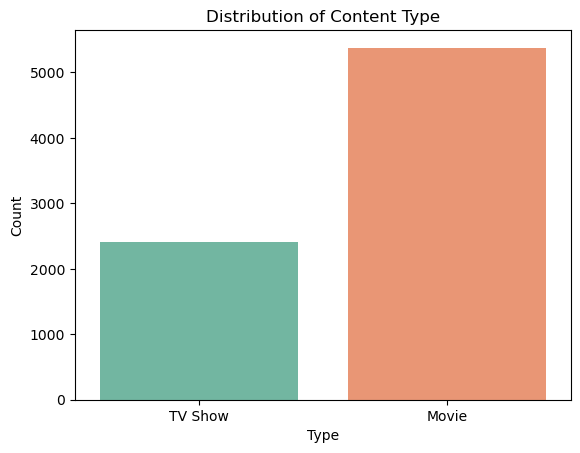

In [49]:
# 1. Content type distribution

sns.countplot(data=df_cleaned, x='type', palette='Set2')
plt.title('Distribution of Content Type')
plt.xlabel('Type')
plt.ylabel('Count')


Text(0, 0.5, 'Country')

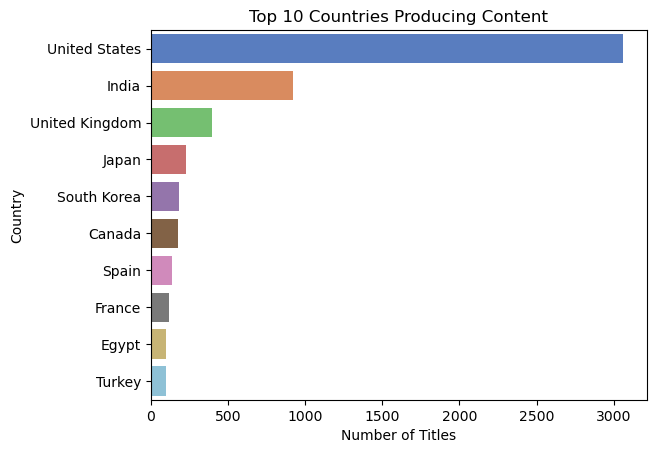

In [50]:
# 2. Top 10 countries producing content

top_countries = df_cleaned['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='muted')
plt.title('Top 10 Countries Producing Content')
plt.xlabel('Number of Titles')
plt.ylabel('Country')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'TV-MA'),
  Text(1, 0, 'TV-14'),
  Text(2, 0, 'TV-PG'),
  Text(3, 0, 'R'),
  Text(4, 0, 'PG-13'),
  Text(5, 0, 'TV-Y'),
  Text(6, 0, 'TV-Y7'),
  Text(7, 0, 'PG'),
  Text(8, 0, 'TV-G'),
  Text(9, 0, 'NR')])

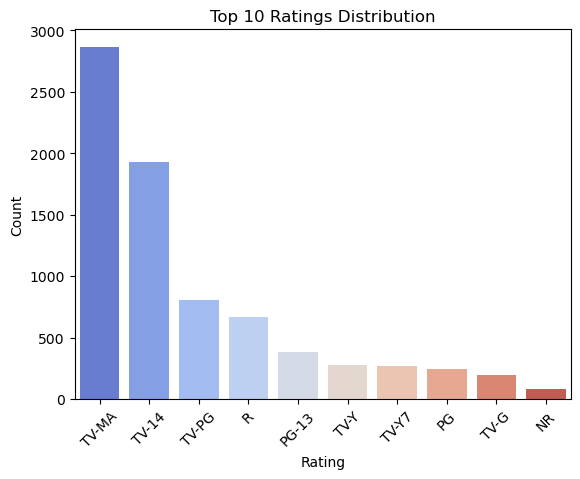

In [51]:
# 3. Ratings distribution

rating_order = df_cleaned['rating'].value_counts().head(10)
sns.barplot(x=rating_order.index, y=rating_order.values, palette='coolwarm')
plt.title('Top 10 Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)

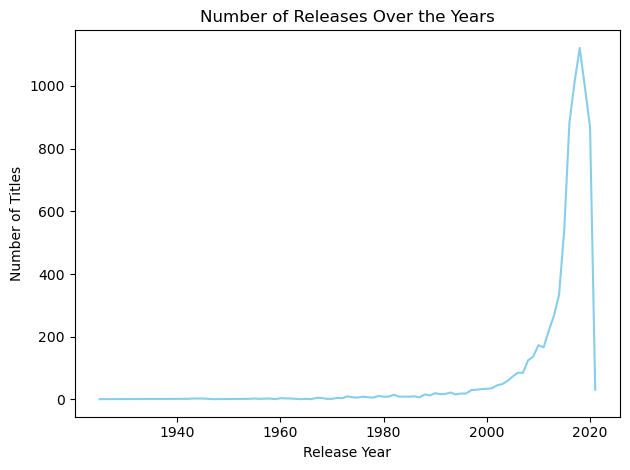

In [52]:
# 4. Content over the years

release_years = df_cleaned['release_year'].value_counts().sort_index()
sns.lineplot(x=release_years.index, y=release_years.values, color='skyblue')
plt.title('Number of Releases Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

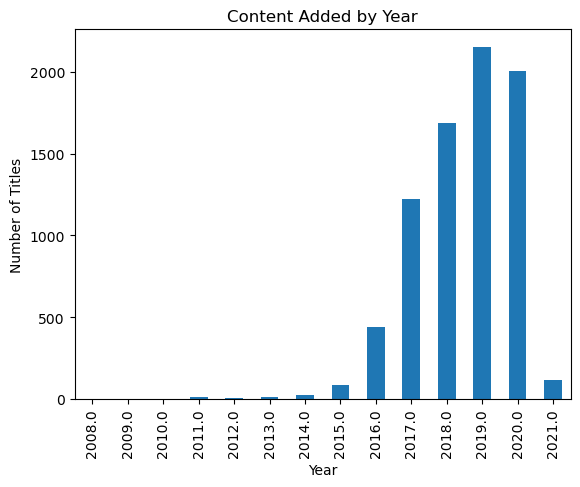

In [53]:
# Clean and convert date_added column
df['date_added'] = df['date_added'].astype(str).str.strip()  # Remove leading/trailing spaces
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')  # Coerce invalid dates to NaT

# Extract year
df['year_added'] = df['date_added'].dt.year

# Plot content added by year
df['year_added'].value_counts().sort_index().plot(kind='bar', title='Content Added by Year')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.show()

# 2.Data Preprocessing

In [55]:
#Data Preprocessing

# 1. Handle Missing Values

# Fill missing values in key columns with 'Unknown'
for col in ['director', 'cast', 'country']:
    df[col] = df[col].fillna('Unknown')

# Convert 'date_added' to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# 2. Convert Categorical Columns

# One-hot encode 'type' and 'rating'
df_encoded = pd.get_dummies(df, columns=['type', 'rating'], prefix=['type', 'rating'])

# Convert duration into numerical and unit
df_encoded['duration_num'] = df_encoded['duration'].str.extract(r'(\d+)').astype(float)
df_encoded['duration_type'] = df_encoded['duration'].str.extract(r'([a-zA-Z]+)')
df_encoded = pd.get_dummies(df_encoded, columns=['duration_type'])


# 3. Standardize Numerical Columns

scaler = StandardScaler()
df_encoded[['release_year', 'duration_num']] = scaler.fit_transform(df_encoded[['release_year', 'duration_num']])

# 4. NLP Feature Extraction

# TF-IDF for 'listed_in'
tfidf_listed = TfidfVectorizer(max_features=50, stop_words='english')
listed_in_tfidf = tfidf_listed.fit_transform(df_encoded['listed_in'].fillna('')).toarray()
listed_in_df = pd.DataFrame(listed_in_tfidf, columns=[f'listed_in_{i}' for i in range(listed_in_tfidf.shape[1])])

# TF-IDF for 'description'
tfidf_desc = TfidfVectorizer(max_features=50, stop_words='english')
desc_tfidf = tfidf_desc.fit_transform(df_encoded['description'].fillna('')).toarray()
desc_df = pd.DataFrame(desc_tfidf, columns=[f'desc_{i}' for i in range(desc_tfidf.shape[1])])

# 5. Final Dataset

# Concatenate all processed features
df_final = pd.concat([df_encoded.reset_index(drop=True), listed_in_df, desc_df], axis=1)

# Drop irrelevant or redundant columns
df_final.drop(columns=[
    'show_id', 'title', 'director', 'cast', 'country',
    'date_added', 'duration', 'listed_in', 'description'
], inplace=True)

# Preview the final dataframe
df_final.head()


,release_year,year_added,type_Movie,type_TV Show,rating_G,rating_NC-17,rating_NR,rating_PG,rating_PG-13,rating_R,...,desc_40,desc_41,desc_42,desc_43,desc_44,desc_45,desc_46,desc_47,desc_48,desc_49
0,0.692878,2020.0,False,True,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.236092,2016.0,True,False,False,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,-0.334890,2018.0,True,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,-0.563284,2017.0,True,False,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.636661,0.0,0.0,0.0
4,-0.677480,2020.0,True,False,False,False,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


# Feature Engineering


In [57]:
# Feature Engineering

# Step 1: Handle missing values for 'release_year' and 'listed_in'
df['release_year'] = df['release_year'].fillna(df['release_year'].median())
df['listed_in'] = df['listed_in'].fillna('Unknown')

# Step 2: Create 'content_age'
current_year = datetime.now().year
df['content_age'] = current_year - df['release_year']

# Step 3: Create 'genre_count'
df['genre_count'] = df['listed_in'].apply(lambda x: len(str(x).split(',')))

# Optional: convert booleans if loaded from preprocessed version
boolean_cols = df.select_dtypes(include=['bool']).columns
df[boolean_cols] = df[boolean_cols].astype(int)

# If you're not using the preprocessed data and need to re-encode categorical values:
# One-hot encode 'type' and 'rating'
df = pd.get_dummies(df, columns=['type', 'rating'], prefix=['type', 'rating'])

# Optionally, scale the 'content_age' and 'genre_count'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['content_age', 'genre_count']] = scaler.fit_transform(df[['content_age', 'genre_count']])

# Preview engineered features
df[['release_year', 'content_age', 'listed_in', 'genre_count']].head()


,release_year,content_age,listed_in,genre_count
0,2020,-0.692878,"International TV Shows, TV Dramas, TV Sci-Fi &...",1.027634
1,2016,-0.236092,"Dramas, International Movies",-0.244574
2,2011,0.334890,"Horror Movies, International Movies",-0.244574
3,2009,0.563284,"Action & Adventure, Independent Movies, Sci-Fi...",1.027634
4,2008,0.677480,Dramas,-1.516781


# Clustering Model Selection


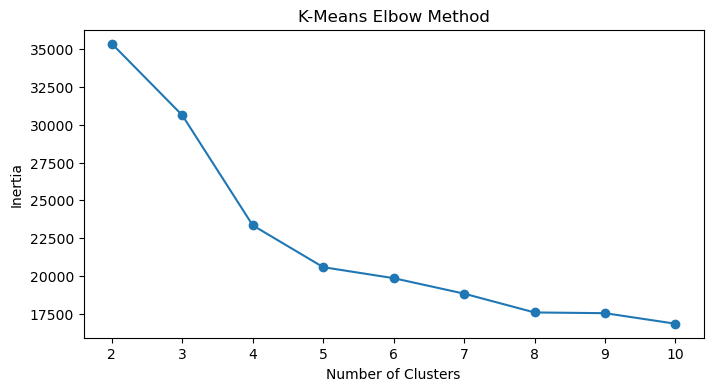

In [59]:
#  Clustering Model Selection
# Load preprocessed dataset (with only numerical columns)
# IMPORTANT: Drop high-dimensional TF-IDF if present, or select key numeric features

# For demonstration, selecting only numerical columns
features = df_final.select_dtypes(include=['float64', 'int64'])
features = features.dropna()

# 1.K-MEANS CLUSTERING

# Elbow Method
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [60]:
# Ensure 'features' and 'df' have same index
features = features.dropna()
df = df.loc[features.index].copy()

# Apply KMeans
kmeans_final = KMeans(n_clusters=4, random_state=42)
df['kmeans_cluster'] = kmeans_final.fit_predict(features)

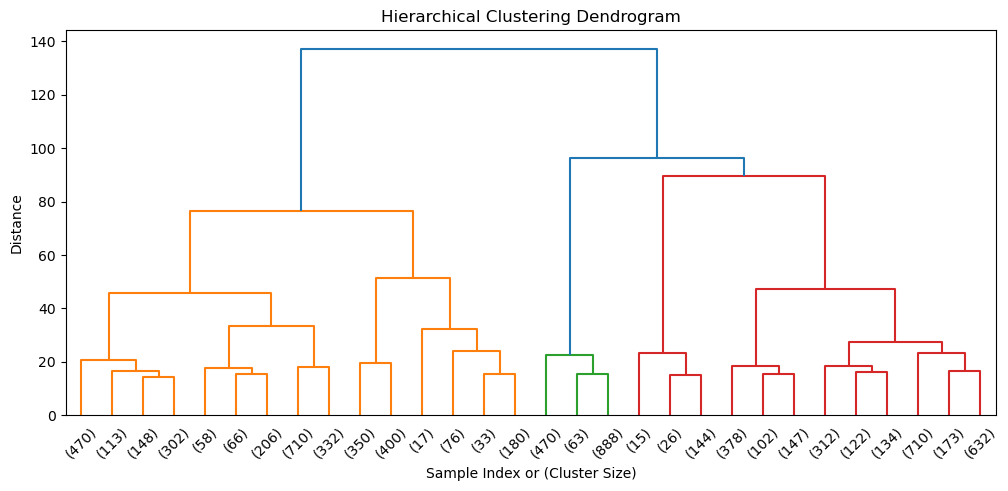

In [61]:
# 2. HIERARCHICAL CLUSTERING

# Generate linkage matrix
link_matrix = linkage(features, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 5))
dendrogram(link_matrix, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

dbscan_cluster
 0    7599
-1     154
 2      13
 1      11
Name: count, dtype: int64


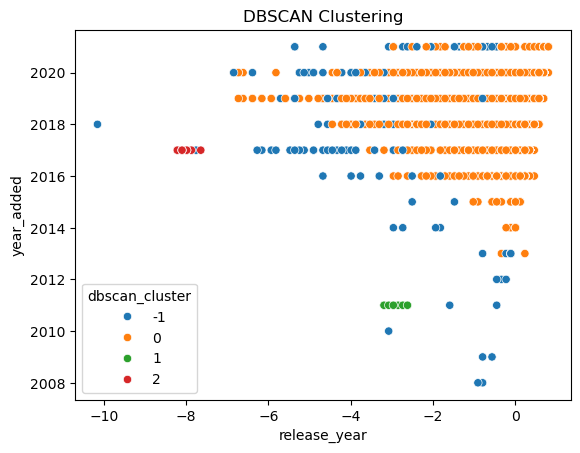

In [62]:
# 3. Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(features)

# View cluster distribution
print(df['dbscan_cluster'].value_counts())

# Visualize DBSCAN result (use 2D projection if needed)
sns.scatterplot(x=features.iloc[:, 0], y=features.iloc[:, 1],
                hue=df['dbscan_cluster'], palette='tab10')
plt.title("DBSCAN Clustering")
plt.show()

# Model Training & Optimization

K-Means Evaluation


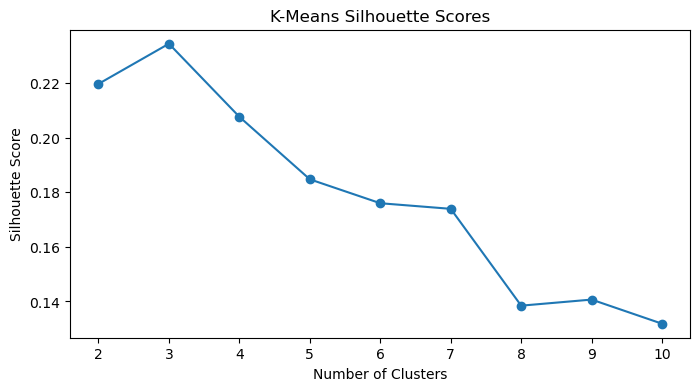

In [64]:
# Use df_final if already in memory, or load from CSV if needed
# df = pd.read_csv("netflix_preprocessed.csv")
features = df_final.select_dtypes(include=['float64', 'int64'])

# Impute any remaining NaNs
imputer = SimpleImputer(strategy='mean')
features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# K-MEANS: Optimal K using silhouette score

print("K-Means Evaluation")
sil_scores = []
K = range(2, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(features)
    sil_scores.append(silhouette_score(features, labels))

plt.figure(figsize=(8, 4))
plt.plot(K, sil_scores, marker='o')
plt.title("K-Means Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Train best model (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
df_final['kmeans_cluster'] = kmeans.fit_predict(features)


🔍 Hierarchical Clustering with 'ward'


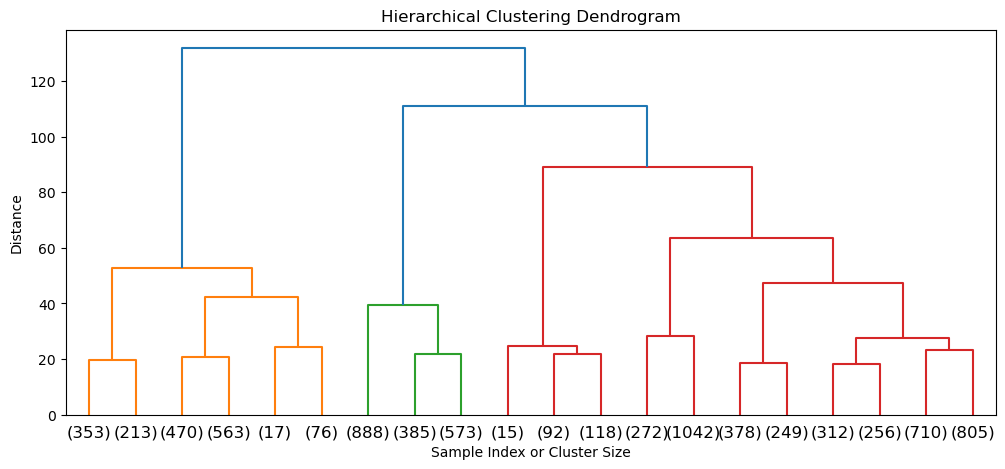

In [65]:
# HIERARCHICAL: Try different linkage methods

print("🔍 Hierarchical Clustering with 'ward'")
link = linkage(features, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(link, truncate_mode='lastp', p=20)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index or Cluster Size")
plt.ylabel("Distance")
plt.show()

agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_final['hierarchical_cluster'] = agg.fit_predict(features)


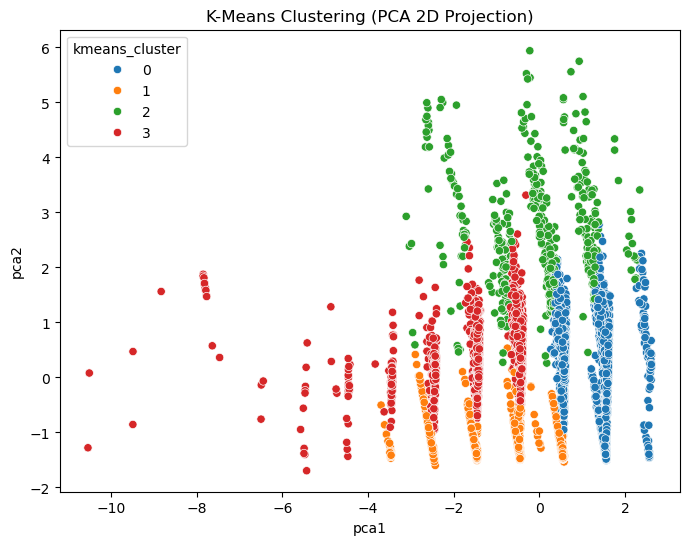

In [66]:
# PCA for 2D Visualization

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df_final['pca1'], df_final['pca2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, x='pca1', y='pca2', hue='kmeans_cluster', palette='tab10')
plt.title("K-Means Clustering (PCA 2D Projection)")
plt.show()


# Visualization & Interpretation

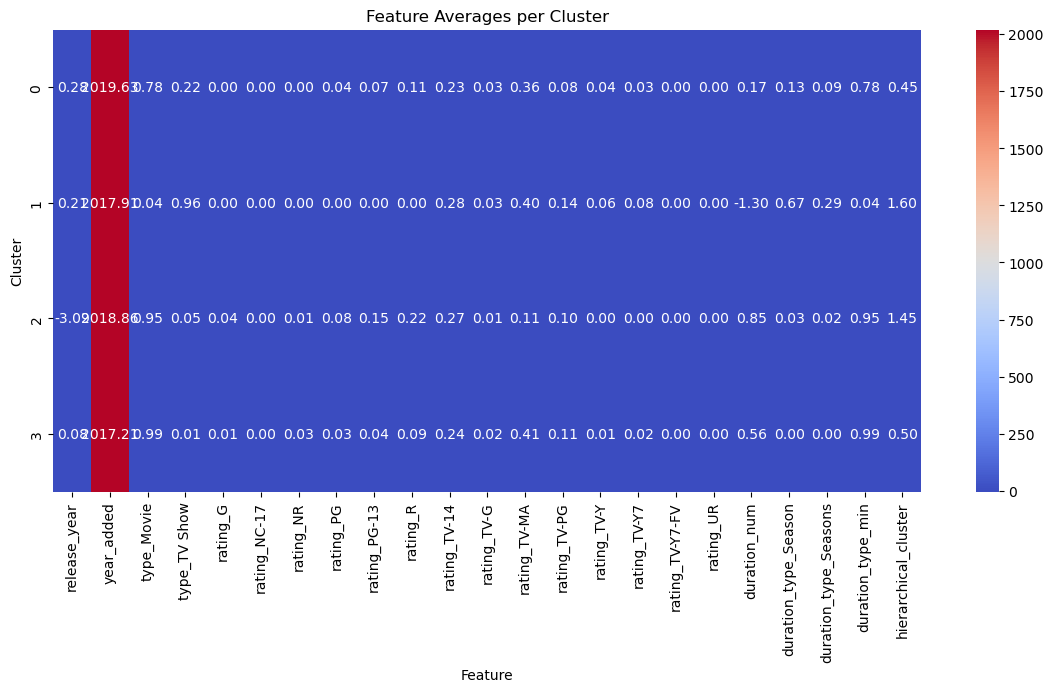

In [68]:
# 1. Heatmap of Cluster Centers

# Group features by cluster mean
cluster_means = df_final.groupby('kmeans_cluster').mean()

# Filter for interpretable features only (remove PCA, TF-IDF if needed)
heatmap_features = [col for col in cluster_means.columns if col not in ['pca1', 'pca2'] and not col.startswith('desc_') and not col.startswith('listed_in_')]

plt.figure(figsize=(14, 6))
sns.heatmap(cluster_means[heatmap_features], cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Feature Averages per Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.show()

In [69]:
# 2. Insights: Common Genres per Cluster

# Re-merge raw genre info (if available)
df_insight = df.copy()
df_insight['cluster'] = df_final['kmeans_cluster']

# Top genres per cluster
from collections import Counter

def get_top_genres(series):
    genre_counter = Counter()
    for entry in series.dropna():
        genres = [g.strip() for g in entry.split(',')]
        genre_counter.update(genres)
    return genre_counter.most_common(5)

for c in sorted(df_insight['cluster'].unique()):
    print(f"\n🎬 Top Genres in Cluster {c}:")
    top_genres = get_top_genres(df_insight[df_insight['cluster'] == c]['listed_in'])
    for genre, count in top_genres:
        print(f"- {genre}: {count} titles")



🎬 Top Genres in Cluster 0:
- International Movies: 1145 titles
- Dramas: 1026 titles
- Comedies: 794 titles
- Independent Movies: 330 titles
- Action & Adventure: 324 titles

🎬 Top Genres in Cluster 1:
- International TV Shows: 881 titles
- TV Dramas: 493 titles
- TV Comedies: 356 titles
- Crime TV Shows: 303 titles
- Romantic TV Shows: 258 titles

🎬 Top Genres in Cluster 2:
- Dramas: 207 titles
- International Movies: 176 titles
- Comedies: 148 titles
- Action & Adventure: 129 titles
- Classic Movies: 101 titles

🎬 Top Genres in Cluster 3:
- International Movies: 1105 titles
- Dramas: 870 titles
- Comedies: 518 titles
- Documentaries: 429 titles
- Independent Movies: 310 titles


# Evaluation & Refinement

In [71]:
# Load or use your preprocessed features
features = df_final.select_dtypes(include=['float64', 'int64'])

# Impute missing values (if any)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Evaluation Function

def evaluate_clustering(model_name, labels, model=None):
    print(f"\n📊 Evaluation for {model_name}")
    try:
        sil_score = silhouette_score(features, labels)
        db_score = davies_bouldin_score(features, labels)
        print(f"Silhouette Score       : {sil_score:.4f}")
        print(f"Davies-Bouldin Index   : {db_score:.4f}")
        if model_name == "KMeans":
            print(f"Inertia                : {model.inertia_:.4f}")
    except Exception as e:
        print(f"❌ Evaluation failed: {e}")


In [72]:
# KMeans Clustering Evaluation

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(features)
evaluate_clustering("KMeans", kmeans_labels, kmeans)

# Hierarchical Clustering Evaluation

agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_labels = agg.fit_predict(features)
evaluate_clustering("Agglomerative", agg_labels)

# DBSCAN Clustering Evaluation

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features)

# Check how many noise points were detected
n_noise = list(dbscan_labels).count(-1)
print(f"\n📦 DBSCAN - Noise Points: {n_noise}")
evaluate_clustering("DBSCAN", dbscan_labels)


📊 Evaluation for KMeans
Silhouette Score       : 0.3371
Davies-Bouldin Index   : 1.0055
Inertia                : 33169.8780

📊 Evaluation for Agglomerative
Silhouette Score       : 0.3344
Davies-Bouldin Index   : 0.9844

📦 DBSCAN - Noise Points: 305

📊 Evaluation for DBSCAN
Silhouette Score       : 0.1803
Davies-Bouldin Index   : 1.6811


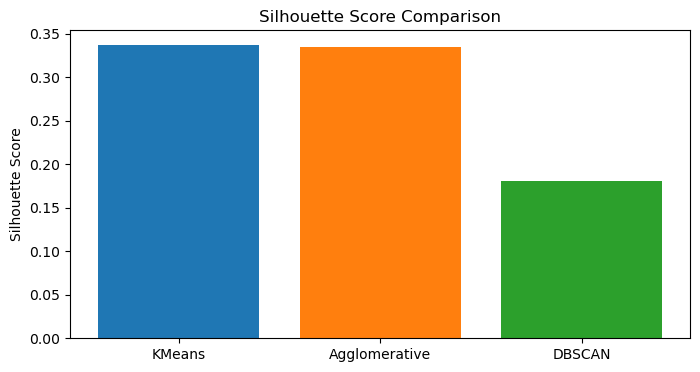

In [73]:
# Compare Models

model_results = {
    "KMeans": kmeans_labels,
    "Agglomerative": agg_labels,
    "DBSCAN": dbscan_labels
}

# Plot silhouette scores comparison (where valid)
from sklearn.metrics import silhouette_samples

plt.figure(figsize=(8, 4))
for name, labels in model_results.items():
    try:
        score = silhouette_score(features, labels)
        plt.bar(name, score)
    except:
        plt.bar(name, 0)
plt.title("Silhouette Score Comparison")
plt.ylabel("Silhouette Score")
plt.show()


# Processed dataset

In [116]:
# Add cluster results to original data
df['kmeans_cluster'] = df_final['kmeans_cluster']
df['hierarchical_cluster'] = df_final['hierarchical_cluster']
df['dbscan_cluster'] = df_final['dbscan_cluster']


In [118]:
df.to_csv("netflix_final_processed_with_clusters.csv", index=False)
